In [1]:
import glam
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt

/Users/pradyumna/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pymc3 as pm

In [3]:
np.random.seed(23) # from random.org

# 3.1. Hierarchical GLAM estimation and out of sample prediction

## Load data

In [4]:
# Load data
sufix = '_Dislike_FixBin5_Dislike_pure_regularGamma_NUTS'
data = pd.read_csv('data/FF2018_data/GlamDataFF2018_Dislike_Bin_v2.csv')
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,0,0,1,3327,0.0,5.0,0.745415,0.254585
1,0,1,1,3424,5.0,4.0,0.410720,0.589280
2,0,2,1,3691,4.0,1.0,0.330549,0.669451
3,0,3,0,8144,3.0,5.0,0.592345,0.407655
4,0,4,0,6559,5.0,5.0,0.641717,0.358283


## Split data in training and test sets

In [5]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

test_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1980 trials) and test (1980 trials) sets...


## Hierarchical GLAM estimation

### 1. full GLAM

In [6]:
# Fitting full GLAM
print('Fitting full GLAM hierarchically...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy')):
    glam_full.make_model('hierarchical', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))   

Fitting full GLAM hierarchically...
Generating hierarchical model for 33 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 1 model(s) using NUTS...
  Fitting model 1 of 1...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, tau_sd, tau_mu, SNR, SNR_sd, SNR_mu, gamma, gamma_sd, gamma_mu, v, v_sd, v_mu]
Sampling 2 chains: 100%|██████████| 6000/6000 [27:40<00:00,  2.40draws/s]
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/!\ Automatically setting parameter precision...


In [7]:
# Save parameter estimates
np.save(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'), glam_full.estimates)
pd.DataFrame(glam_full.estimates)

,SNR,SNR_mu,SNR_sd,b,gamma,gamma_mu,gamma_sd,p_error,s,t0,tau,tau_mu,tau_sd,v,v_mu,v_sd
0,148.21,166.52,36.62,1.0,-1.00,-0.99,0.0,0.05,0.006786,0.0,0.43,0.97,0.58,0.000047,0.000052,0.000011
1,163.33,166.52,36.62,1.0,-0.99,-0.99,0.0,0.05,0.009743,0.0,0.15,0.97,0.58,0.000056,0.000052,0.000011
2,142.20,166.52,36.62,1.0,-0.99,-0.99,0.0,0.05,0.007988,0.0,0.01,0.97,0.58,0.000049,0.000052,0.000011
3,213.60,166.52,36.62,1.0,-0.99,-0.99,0.0,0.05,0.007995,0.0,1.08,0.97,0.58,0.000046,0.000052,0.000011
4,175.49,166.52,36.62,1.0,-0.99,-0.99,0.0,0.05,0.010133,0.0,1.95,0.97,0.58,0.000058,0.000052,0.000011
5,189.06,166.52,36.62,1.0,-1.00,-0.99,0.0,0.05,0.008901,0.0,0.67,0.97,0.58,0.000054,0.000052,0.000011
6,136.35,166.52,36.62,1.0,-0.99,-0.99,0.0,0.05,0.009745,0.0,0.88,0.97,0.58,0.000064,0.000052,0.000011
7,118.19,166.52,36.62,1.0,-1.00,-0.99,0.0,0.05,0.006752,0.0,1.70,0.97,0.58,0.000053,0.000052,0.000011
8,119.61,166.52,36.62,1.0,-0.99,-0.99,0.0,0.05,0.007595,0.0,0.93,0.97,0.58,0.000055,0.000052,0.000011
9,121.19,166.52,36.62,1.0,-1.00,-0.99,0.0,0.05,0.009703,0.0,1.58,0.97,0.58,0.000065,0.000052,0.000011


In [8]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_FF2018_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full.waic = np.load(str('results/waic/glam_FF2018_full'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_FF2018_full'+ sufix +'.npy'), glam_full.waic)

Computing WAIC scores for full model...


/Users/pradyumna/anaconda/lib/python3.5/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [9]:
glam_full.waic

WAIC_r(WAIC=36048.658126681, WAIC_se=0.0, p_WAIC=91.90353650549535, var_warn=1)

In [10]:
glam_full.trace

<MultiTrace: 2 chains, 2000 iterations, 28 variables>

In [11]:
# Compute LOO

glam_full.loo = pm.loo(trace=glam_full.trace, model=glam_full.model)
glam_full.loo

/Users/pradyumna/anaconda/lib/python3.5/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=35955.65785802655, LOO_se=0.0, p_LOO=45.40340217826815, shape_warn=1)

In [12]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1980 trials) with new data (1980 trials)...


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1
0,1.0,0.0,4795.0,0.0,0.0,5.0,0.41072,4.0,0.58928
1,1.0,1.0,2097.0,0.0,0.0,5.0,0.41072,4.0,0.58928
2,1.0,2.0,4248.0,0.0,0.0,5.0,0.41072,4.0,0.58928
3,1.0,3.0,3291.0,0.0,0.0,5.0,0.41072,4.0,0.58928
4,1.0,4.0,2873.0,0.0,0.0,5.0,0.41072,4.0,0.58928


### 1. no-bias GLAM

In [14]:
# Fitting no-bias GLAM
print('Fitting no-bias GLAM hierarchically...')

glam_nobias = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy')):
    glam_nobias.make_model('hierarchical', gamma_val=1.0, t0_val=0)
    glam_nobias.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_nobias.estimates = np.load(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy'))
    
# Save parameter estimates

Fitting no-bias GLAM hierarchically...
Generating hierarchical model for 33 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 1 model(s) using NUTS...
  Fitting model 1 of 1...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, tau_sd, tau_mu, SNR, SNR_sd, SNR_mu, v, v_sd, v_mu]
Sampling 2 chains: 100%|██████████| 6000/6000 [22:34<00:00,  4.43draws/s]
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.652344233403715, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


In [15]:
np.save(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy'), glam_nobias.estimates)
pd.DataFrame(glam_nobias.estimates)

,SNR,SNR_mu,SNR_sd,b,gamma,p_error,s,t0,tau,tau_mu,tau_sd,v,v_mu,v_sd
0,169.77,167.95,38.6,1.0,1.0,0.05,0.006865,0.0,0.0,0.0,0.0,0.000043,0.000053,0.000011
1,162.74,167.95,38.6,1.0,1.0,0.05,0.009486,0.0,0.0,0.0,0.0,0.000052,0.000053,0.000011
2,178.66,167.95,38.6,1.0,1.0,0.05,0.007639,0.0,0.0,0.0,0.0,0.000049,0.000053,0.000011
3,172.70,167.95,38.6,1.0,1.0,0.05,0.009075,0.0,0.0,0.0,0.0,0.000046,0.000053,0.000011
4,173.00,167.95,38.6,1.0,1.0,0.05,0.013727,0.0,0.0,0.0,0.0,0.000056,0.000053,0.000011
5,168.18,167.95,38.6,1.0,1.0,0.05,0.009801,0.0,0.0,0.0,0.0,0.000058,0.000053,0.000011
6,123.48,167.95,38.6,1.0,1.0,0.05,0.008673,0.0,0.0,0.0,0.0,0.000061,0.000053,0.000011
7,142.27,167.95,38.6,1.0,1.0,0.05,0.007646,0.0,0.0,0.0,0.0,0.000054,0.000053,0.000011
8,129.25,167.95,38.6,1.0,1.0,0.05,0.007321,0.0,0.0,0.0,0.0,0.000054,0.000053,0.000011
9,150.92,167.95,38.6,1.0,1.0,0.05,0.009372,0.0,0.0,0.0,0.0,0.000064,0.000053,0.000011


In [16]:
# Compute LOO
glam_nobias.loo = pm.loo(trace=glam_nobias.trace, model=glam_nobias.model)
glam_nobias.loo

/Users/pradyumna/anaconda/lib/python3.5/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=36564.59092802278, LOO_se=0.0, p_LOO=38.59730530762681, shape_warn=1)

In [17]:
# Predictions
print('Predicting test set data using no-bias GLAM...')
glam_nobias.exchange_data(test_data)
 
if not os.path.exists(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv')):
     glam_nobias.predict(n_repeats=50)
     glam_nobias.prediction.to_csv(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv'), index=False)
else:
     print('  Found old hierarchical no-bias GLAM predictions in "results/predictions". Skipping prediction...')
     glam_nobias.prediction = pd.read_csv(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv'))
glam_nobias.prediction.head()

Predicting test set data using no-bias GLAM...
Replaced attached data (1980 trials) with new data (1980 trials)...


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1
0,1.0,0.0,2763.0,0.0,0.0,5.0,0.41072,4.0,0.58928
1,1.0,1.0,1655.0,0.0,0.0,5.0,0.41072,4.0,0.58928
2,0.0,2.0,2737.0,0.0,0.0,5.0,0.41072,4.0,0.58928
3,0.0,3.0,2778.0,0.0,0.0,5.0,0.41072,4.0,0.58928
4,1.0,4.0,2758.0,0.0,0.0,5.0,0.41072,4.0,0.58928


## 2. Plot fit

Close Figure to continue...


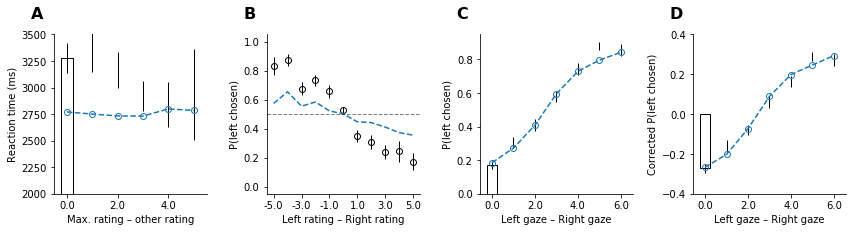

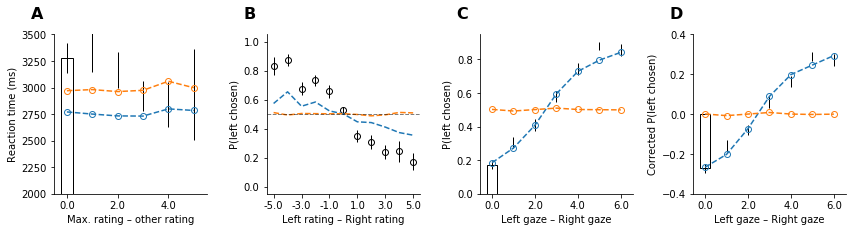

In [18]:
print('Close Figure to continue...')
glam.plot_fit(test_data, [glam_full.prediction]);
glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);

plt.show()

## Parameters for full hierarchical model

In [ ]:
params_part = glam_full.estimates.item(0)
params_part = pd.DataFrame.from_dict(glam_full.estimates.item(0))

In [ ]:
params_part

## [END] 

In [ ]:
testa = glam_nobias.prediction

In [ ]:
xlims =(0, 10)

# Compute relevant variables
df = glam.plots.add_difficulty(testa)

# Compute summary statistics
subject_means = df.groupby(['subject', 'difficulty']).rt.mean()
means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]


In [ ]:
means